# Fitting Description

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/digital_breakthrough/task_3

/content/drive/MyDrive/digital_breakthrough/task_3


In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,448 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [1]:
cd /content/drive/MyDrive/digital_breakthrough/task_3

/content/drive/MyDrive/digital_breakthrough/task_3


## Load Data

In [2]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
sys.path.append('.')
from definitions import ROOT_DIR
from airotica.utils import read_image

In [3]:
DATA_PATH = ROOT_DIR / 'data'
TRAIN_IMAGES = DATA_PATH / 'images'
DOWNLOADED_TRAIN_IMAGES = DATA_PATH / 'downloaded_images'

In [4]:
train = pd.read_csv(DATA_PATH / 'train.csv')
train_url_only = pd.read_csv(DATA_PATH / 'train_url_only.csv')
train_url_loaded_images = pd.read_csv(DATA_PATH / 'train_loaded_images.csv')
test = pd.read_csv(DATA_PATH / 'test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'sample_submission.csv')

In [5]:
import os
from os import listdir
train_images = listdir(TRAIN_IMAGES)
guid_train_images = [f.split('.')[0] for f in train_images if os.path.getsize(f"{str(TRAIN_IMAGES / f)}") != 0]

In [6]:
dummy = test[test.guid.isin(guid_train_images)]
test_only_description = test[~(test.guid.isin(guid_train_images))]
test_only_images = dummy[dummy.description.isna()]
test_images_and_description = dummy[~(dummy.description.isna())]
print('without image or description:', len(test_only_description[test_only_description.description.isna()]))
print('only description:', test_only_description.shape[0])
print('only images:', test_only_images.shape[0])
print('images and description:', test_images_and_description.shape[0])

without image or description: 0
only description: 106
only images: 547
images and description: 570


In [72]:
import os
import sys
import torch
import yaml
import logging
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

sys.path.append('.')
from definitions import ROOT_DIR
from airotica.utils import save_checkpoint, convert_dict_to_tuple
from airotica.models import load_model
from airotica.loss_function import get_loss
from airotica.optimizers import (
    get_optimizer,
    get_scheduler
)
from airotica.dataset import get_data_loaders
from airotica.train import train as train_model, validation
from airotica.airotica import detectron

%matplotlib inline
%load_ext autoreload
%autoreload 2

log = logging.getLogger(__name__)

DATA_PATH = ROOT_DIR / 'data'
CONFIG_PATH = ROOT_DIR / 'config5.yml'

with open(CONFIG_PATH) as f:
    data = yaml.safe_load(f)
config = convert_dict_to_tuple(dictionary=data)

device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
print(f'device: {device_name}')

seed = config.dataset.seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

os.environ['CUDA_VISIBLE_DEVICES'] = config.cuda_id

{"asctime": "2021-08-02 11:28:07", "name": "matplotlib.pyplot", "filename": "pyplot.py", "levelname": "DEBUG", "message": "Loaded backend module://ipykernel.pylab.backend_inline version unknown."}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cpu


In [73]:
op = detectron(config, 
          './sub/class_6_prediction.csv', 
          './EXPERIMENTS/classes_3.4.6.10.13/model_0002_0.887871.pth', 
          'resnext101_32x8d',
          use_description=True)

100%|██████████| 1223/1223 [10:32<00:00,  1.93it/s]


In [76]:
up = pd.read_csv('./sub/class_6_prediction.csv')

In [81]:
mapper = {0: 3,
          1: 4,
          2: 6,
          3: 10,
          4: 13,
          5: -2,
          -1: -1
          }

In [82]:
up['label'] = up['sign_0'].map(mapper)

In [87]:
tm = pd.read_csv('./sub/img_with_distilbert.csv')

In [89]:
up['guid'] = up['filename']

In [91]:
ru = tm.merge(up[up.label.isin([0, 1, 2, 3, 4])], on='guid')

In [92]:
ru

,guid,typology,sign_0,filename,label
0,a2c8e732-876b-48ef-9b04-9a6fc5e0594e,предметы археологии,1.0,a2c8e732-876b-48ef-9b04-9a6fc5e0594e,4
1,84f0d0a8-e1f4-419a-8db8-c349cf1a4aee,предметы археологии,1.0,84f0d0a8-e1f4-419a-8db8-c349cf1a4aee,4
2,668d6709-95f8-4406-893d-bd4e2190e2fc,предметы археологии,1.0,668d6709-95f8-4406-893d-bd4e2190e2fc,4
3,1f6cf67c-612d-4c18-850a-8955fe4092ee,оружие,0.0,1f6cf67c-612d-4c18-850a-8955fe4092ee,3
4,8b8ac0bf-183f-43c3-b930-9c5722545203,предметы археологии,1.0,8b8ac0bf-183f-43c3-b930-9c5722545203,4
...,...,...,...,...,...
75,be6434b6-ebf5-4c83-9135-ca64e4d348b1,предметы археологии,1.0,be6434b6-ebf5-4c83-9135-ca64e4d348b1,4
76,6900941b-0e4d-4df5-94cd-ae3088439a17,предметы археологии,1.0,6900941b-0e4d-4df5-94cd-ae3088439a17,4
77,721bfa6d-3fab-484f-a546-1dc1d3d54270,предметы археологии,1.0,721bfa6d-3fab-484f-a546-1dc1d3d54270,4
78,4f26fa74-f0de-4c8f-96c3-de27f04a14b6,предметы археологии,1.0,4f26fa74-f0de-4c8f-96c3-de27f04a14b6,4


In [96]:
ru['label_pred'] = ru['label'].map(categories.to_dict()['category'])

In [99]:
pe = pd.read_csv('./sub/img_with_distilbert.csv')
pe.loc[ru[ru.typology != ru.label_pred].index, 'typology'] = ru[ru.typology != ru.label_pred].label_pred.values

In [102]:
pe.to_csv('./sub/better_img.csv', index=False)

In [105]:
from airotica.utils import read_image
import matplotlib.pyplot as plt

def visual(df):
    for i, row in df.iterrows():
        guid = row['guid']
        img = read_image(str(TRAIN_IMAGES / f'{guid}.jpg'))
        plt.imshow(img)
        plt.title(f"{row['label_pred']}, {row['typology']}")
        plt.show()

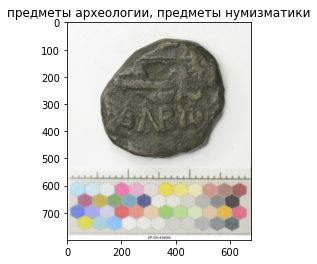

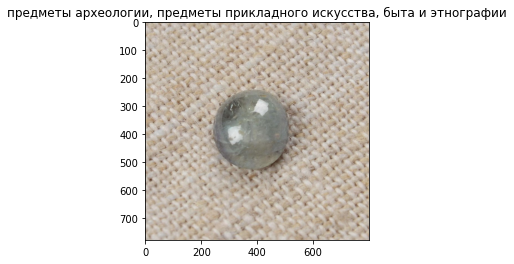

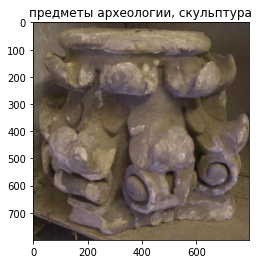

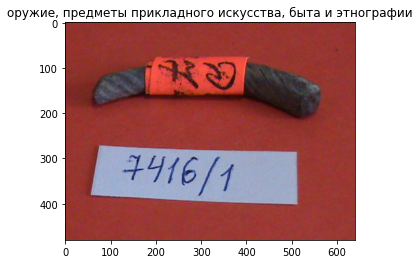

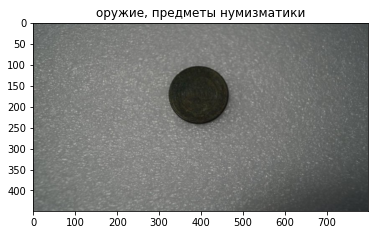

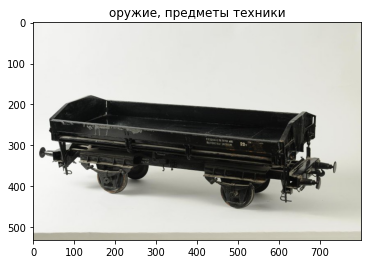

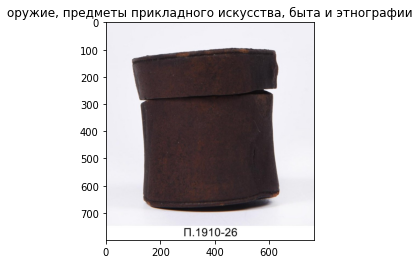

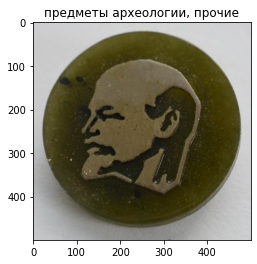

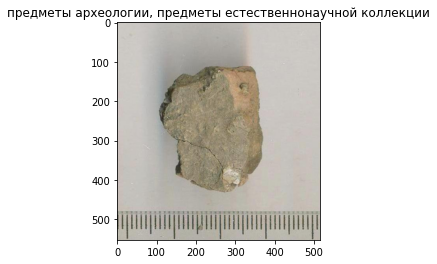

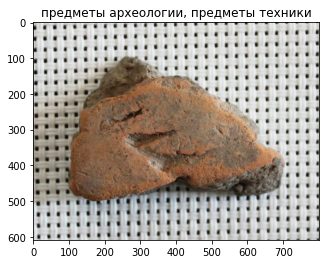

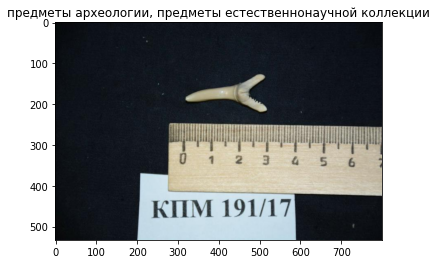

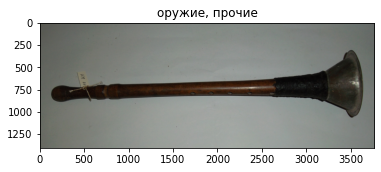

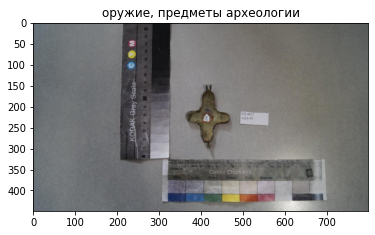

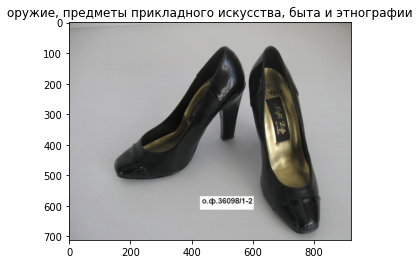

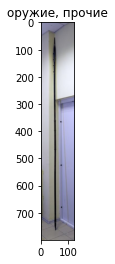

In [106]:
visual(ru[ru.typology != ru.label_pred])

In [79]:
up[up.sign_0 != -1].sign_0.value_counts()

5.0    434
1.0     69
3.0     19
0.0     11
2.0      8
4.0      6
Name: sign_0, dtype: int64

In [11]:
# IMPORT
import cv2
import random
import os
import torch
import logging
import numpy as np
import pandas as pd
import albumentations as A

# FROM
from tqdm import tqdm
from torchvision import transforms as tfs
from pathlib import Path
from airotica.augmentations import ValidationAugmentations

from airotica.utils import (
    load_resnet,
    save_results,
)


log = logging.getLogger(__name__)


def detectron(config,
              save_path: str,
              model_path: str,
              model_type: str,
              test_df=None,
              number_of_images=10,
              experiment=False,
              use_description=False):

    seed = config.dataset.seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

    os.environ['CUDA_VISIBLE_DEVICES'] = config.cuda_id
    device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = load_resnet(
        path=model_path,
        model_type=model_type,
        num_classes=config.dataset.num_of_classes,
        device=device_name
    )

    softmax_func = torch.nn.Softmax(dim=1)
    validation_augmentation = ValidationAugmentations(config=config)
    preprocess = tfs.Compose(
        [
            tfs.ToTensor(),
            tfs.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
    if test_df is None:
        test_df = pd.read_csv(config.path.input_path)
    test_image_path = Path(config.path.test_images_path)
    len_ = len(test_df)
    if not experiment:
        scores = np.zeros((len_, 1), dtype=np.float32)
        for idx, row in tqdm(test_df.iterrows(), total=len_):
            if use_description:
                if not pd.isnull(row['description']):
                    scores[idx] = -1
                    continue

            guid = row['guid']
            path = str(test_image_path / f'{guid}.jpg')
            img = cv2.imread(path,
                             cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
            if img is None:
                print(f'None img {path}')
                continue

            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            crop, _ = validation_augmentation(
                image=img,
                annotation=None
            )
            crop = preprocess(crop).unsqueeze(0)
            crop = crop.to(device_name)
            out = model(crop)
            out = softmax_func(out).squeeze().detach().cpu().numpy()
            scores[idx] = np.argmax(out)
        return scores

In [16]:
scores = detectron(config, 
          './sub/prediction_images.csv', 
          './EXPERIMENTS/resnext152/model_0007_0.755441.pth', 
          'resnext101_32x8d',
          test_df=test_images_and_description.reset_index(drop=True),
          use_description=False)

100%|██████████| 570/570 [06:25<00:00,  1.48it/s]


In [20]:
tim = test_images_and_description.copy()

In [31]:
tim['typology'] = scores

In [37]:
categories = pd.read_csv('./data/description/categories.csv')

In [43]:
from utils import read_image

{0: 'графика',
 1: 'документы',
 2: 'живопись',
 3: 'оружие',
 4: 'предметы археологии',
 5: 'предметы естественнонаучной коллекции',
 6: 'предметы минералогической коллекции',
 7: 'предметы нумизматики',
 8: 'предметы печатной продукции',
 9: 'предметы прикладного искусства, быта и этнографии',
 10: 'предметы техники',
 11: 'прочие',
 12: 'редкие книги',
 13: 'скульптура',
 14: 'фотографии и негативы'}

In [44]:
du = tim.merge(res.loc[v.index], on='guid')

In [58]:
po = pd.read_csv('./sub/img_with_distilbert.csv')

In [61]:
po.loc[me.index, 'typology'] = me.typ_1.values

In [64]:
po.to_csv('./sub/img_pred.csv', index=False)

In [48]:
me = du[du.typ_1 != du.typology_y]

In [49]:
me

,guid,description,typology_x,typology_y,typ_1
5,20029a89-3d62-408e-bb15-afe50265c53f,Диафильм для детей «Конек – Горбунок. Часть 4»,10.0,прочие,предметы техники
8,25de735d-d2be-47be-a98c-d3c3282f295f,Ступа,13.0,"предметы прикладного искусства, быта и этнографии",скульптура
11,d49d4f37-1ca0-428a-9deb-090da47e98eb,Образец ткани Киржачского шелкового комбината ...,12.0,прочие,редкие книги
12,1a832d2c-d86d-493e-9ac2-4db6222c63e0,Пряслице,5.0,предметы археологии,предметы естественнонаучной коллекции
15,2e63de61-bdc3-4730-9068-f0997ad33a1c,Украшение елочное. Шар стеклянный прозрачный о...,11.0,"предметы прикладного искусства, быта и этнографии",прочие
...,...,...,...,...,...
544,8ced0c61-dfba-4e1d-80a1-9efff3eee6c8,Фотография (групповая). Слева направо: О.В. Ан...,12.0,фотографии и негативы,редкие книги
549,33375023-a575-404e-8c82-6f110d8aa048,Бусина из вязки,9.0,предметы археологии,"предметы прикладного искусства, быта и этнографии"
550,c9e573ae-48f0-484e-8e0d-af4eec8da6a7,"Медаль памятная ""XXII Олимпиада. Москва"" Анань...",13.0,предметы нумизматики,скульптура
552,d6c41f39-d253-4b18-92b4-6b6fdc1e754f,Журнал. The fortnightly review. Edited by John...,1.0,редкие книги,документы


In [32]:
v = test[~(test.description.isna())]

In [23]:
res = pd.read_csv('./sub/img_with_distilbert.csv')
res

,guid,typology
0,a74014d7-3054-45bd-b284-ac117ccd2001,предметы нумизматики
1,783eab83-a48c-4950-996a-386fe93a3ccd,"предметы прикладного искусства, быта и этнографии"
2,8e7e2514-fab3-4287-be06-aae93c5397e0,графика
3,dc1964ce-9248-4fe7-9d4b-c110ac270f64,живопись
4,1dd23c5e-bf5d-45b7-9894-07bfdf91ae80,документы
...,...,...
1218,abc933b7-ea83-4d06-a09b-67183c3fb283,прочие
1219,e0f8ca73-5092-48dd-ade9-35f862635073,документы
1220,2519dcdf-3cb2-44cc-9a39-80ff704ca56d,предметы нумизматики
1221,14327710-ad5f-4aff-90ad-b0cf78265f41,графика


## Data Visualisation

In [ ]:
trained = pd.read_csv('./data/full_images_data.csv')
label_to_typology = {v: k for k, v in typology_to_label.items()}
for i in range(15):
    globals()[f'label_{i}'] = trained[trained['label'] == i]
    print(globals()[f'label_{i}'].shape[0], label_to_typology[i], i)

14027 графика 0
24186 документы 1
3365 живопись 2
695 оружие 3
22153 предметы археологии 4
4074 предметы естественнонаучной коллекции 5
1431 предметы минералогической коллекции 6
21596 предметы нумизматики 7
19836 предметы печатной продукции 8
21262 предметы прикладного искусства, быта и этнографии 9
1532 предметы техники 10
8244 прочие 11
7746 редкие книги 12
505 скульптура 13
28772 фотографии и негативы 14


### Label 0 - Графика

In [ ]:
from airotica.utils import read_image
import matplotlib.pyplot as plt

def visualise(df, how_many=10):
    count = 0
    for i, row in df.iterrows():
        g = row['guid']
        add = row['add']
        try:
            if add == 0:
                img = read_image(str(TRAIN_IMAGES / f'{g}.jpg'))
            else:
                img = read_image(str(DOWNLOADED_TRAIN_IMAGES / f'{g}.jpg'))
            plt.imshow(img)
            plt.show()
            count += 1
        except ValueError as ex:
            print(ex)
        if count == how_many:
            break

In [ ]:
for i in range(15):
    print(label_to_typology[i])
    visualise(globals()[f'label_{i}'], 8)
    print('end')

Output hidden; open in https://colab.research.google.com to view.

### Tesseract

In [107]:
import pytesseract

# pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [108]:
cd /usr/share/tesseract-ocr/4.00/tessdata/

/usr/share/tesseract-ocr/4.00/tessdata


In [109]:
!wget https://github.com/tesseract-ocr/tessdata/raw/master/rus.traineddata

--2021-08-02 12:16:04--  https://github.com/tesseract-ocr/tessdata/raw/master/rus.traineddata
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/master/rus.traineddata [following]
--2021-08-02 12:16:04--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/master/rus.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19920885 (19M) [application/octet-stream]
Saving to: ‘rus.traineddata’

rus.traineddata     100%[===================>]  19.00M   121MB/s    in 0.2s    

2021-08-02 12:16:04 (121 MB/s) - ‘rus.traineddata’ saved [19920885/19920885]



In [110]:
cd /content/drive/MyDrive/digital_breakthrough/task_3

/content/drive/MyDrive/digital_breakthrough/task_3


In [119]:
from airotica.utils import read_image
import matplotlib.pyplot as plt
d = {}
for i in test_only_images.guid:
    img = read_image(str(TRAIN_IMAGES / f'{i}.jpg'))
    try:
        p = pytesseract.image_to_string(img, lang='rus')
    #plt.imshow(img)
        d[i] = p
    except Exception as ex:
        d[i] = ''
        continue
    #plt.show()

In [122]:
test_only_images['description'] = test_only_images['guid'].map(d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
d

{'0051bcf7-197d-41be-bcd8-73fcf8e46cfd': ' \n\x0c',
 '00ff419e-e1fd-46f1-8abc-8e1b012c1e48': ' \n\x0c',
 '01774486-2287-42f2-a71f-aa896ee6fd46': ' \n\n  \n\nь #в р ов очь оь аь ав й —\n\nра е\nі щ\n\n@\n\n@\n\n*\n\nя\n\nГ |\n\n"\n\n*\n\n1 -опс„.\nь\n\nлд б тр\n\x0c',
 '021d6f40-bd41-4148-9ab7-2ddcd6e894ad': '=\nй\n3 і\n\n \n\x0c',
 '02c99722-f2ad-42a3-b831-f9397c218ff0': ' \n\x0c',
 '02db9cc2-bd27-4a6a-bb92-7947cab42445': '   \n\x0c',
 '034fe150-9386-4088-9728-a45ff6d3ad8b': ' \n\x0c',
 '03c4050e-11ef-4dac-b766-c0dbe06118a7': ' \n\x0c',
 '03cf8878-07a1-431b-b90c-ca1b89586b23': '    \n  \n  \n\nИЛенумо ов\n\n \n \n\nСЪЕЗДОВСКАЯ\nГдоВАЯ ВАХТА\n\nУНЕ кеа\n!\n\nДНЕВНИК ПОЛЕВЫХ РАБОТ\n\nзадания\n\nСг жтотиооь м.\n\n„|Епосоеоиосо| К предстоящей зимовке\n\n"| ое ее оо лоа ,\nст ооаунтом закунок У осорее Чайое простельноя ©\nо оо 13 Таа | аеа па ае в Эее лоы\n[1 оее че на 300 пнг | ооа дагите Е дбичсто, сте Яеглоннча Аненмда М! ост о\nУЗШЕо БЕтя ПОбОЕОЬЛИЕ НО оЫ И\nМа ои аы мк оее о ае\nМоокол

In [164]:
cd /content/drive/MyDrive/digital_breakthrough/task_3

/content/drive/MyDrive/digital_breakthrough/task_3


In [133]:
test_only_images.to_csv('./data/description/text_from_image.csv')

In [169]:
test_only_images.to_csv('./data/description/text_from_image.csv', index=False)

In [170]:
test_only_images

,guid,description,typology,me
0,a74014d7-3054-45bd-b284-ac117ccd2001,\n,NaN,
2,8e7e2514-fab3-4287-be06-aae93c5397e0,\n,NaN,
5,094e1f33-5488-43be-b7b7-e595a9a3a054,\n,NaN,
9,2f281a43-71e7-450b-b4c6-0373bb944f17,,NaN,
10,034fe150-9386-4088-9728-a45ff6d3ad8b,\n,NaN,
...,...,...,...,...
1213,d6db3b9e-bc90-4dee-8880-a46f1ea9dd63,\n,NaN,
1214,873b7bee-08da-472b-abdf-6ffd2d793491,\n\nМООЕКЛМЕ\nСАГБЕКЕ\n\nТеайптегтг: # — Агсо...,NaN,мооеклме сагбеке теайптегтг агсора в г ашхутрш...
1218,abc933b7-ea83-4d06-a09b-67183c3fb283,7\nИра\n\n \n,NaN,ира
1219,e0f8ca73-5092-48dd-ade9-35f862635073,\n,NaN,


In [135]:
cd /content/drive/MyDrive/bert/notebooks/

/content/drive/MyDrive/bert/notebooks


In [147]:
import re
import time
import nltk
import string
import numpy as np
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [156]:
def text_prepare(text):
    """
        text: a string
        
        return: modified string
    """
    lemmatizer = WordNetLemmatizer()
    
    # 1. Перевести символы в нижний регистр
    text = text.lower() #your code
    
    # 2.1 Заменить символы пунктуации на пробелы
    text = re.sub(r'[{}]'.format(string.punctuation), ' ', text)
    
    # 2.2 Удалить "плохие" символы
    text = re.sub('[^А-Яа-я]', ' ', text)
    
    # 3. Применить WordNetLemmatizer
    word_list = nltk.word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    
    # 4. Удалить стопслова.
    stopWords = set(stopwords.words('english'))
    for stopWord in stopWords:
        text = re.sub(r'\b{}\b'.format(stopWord), '', text)
    
    # 5. Удаляю пробелы у получая просто строку слов через пробел
    text = ' '.join(text.split())
    return text

In [157]:
test_only_images['me'] = test_only_images.description.apply(text_prepare)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [161]:
len(test_only_images.me.values)

547

In [163]:
from src.predict import prediction

ModuleNotFoundError: ignored

In [140]:
d

{'0051bcf7-197d-41be-bcd8-73fcf8e46cfd': ' \n\x0c',
 '00ff419e-e1fd-46f1-8abc-8e1b012c1e48': ' \n\x0c',
 '01774486-2287-42f2-a71f-aa896ee6fd46': ' \n\n  \n\nь #в р ов очь оь аь ав й —\n\nра е\nі щ\n\n@\n\n@\n\n*\n\nя\n\nГ |\n\n"\n\n*\n\n1 -опс„.\nь\n\nлд б тр\n\x0c',
 '021d6f40-bd41-4148-9ab7-2ddcd6e894ad': '=\nй\n3 і\n\n \n\x0c',
 '02c99722-f2ad-42a3-b831-f9397c218ff0': ' \n\x0c',
 '02db9cc2-bd27-4a6a-bb92-7947cab42445': '   \n\x0c',
 '034fe150-9386-4088-9728-a45ff6d3ad8b': ' \n\x0c',
 '03c4050e-11ef-4dac-b766-c0dbe06118a7': ' \n\x0c',
 '03cf8878-07a1-431b-b90c-ca1b89586b23': '    \n  \n  \n\nИЛенумо ов\n\n \n \n\nСЪЕЗДОВСКАЯ\nГдоВАЯ ВАХТА\n\nУНЕ кеа\n!\n\nДНЕВНИК ПОЛЕВЫХ РАБОТ\n\nзадания\n\nСг жтотиооь м.\n\n„|Епосоеоиосо| К предстоящей зимовке\n\n"| ое ее оо лоа ,\nст ооаунтом закунок У осорее Чайое простельноя ©\nо оо 13 Таа | аеа па ае в Эее лоы\n[1 оее че на 300 пнг | ооа дагите Е дбичсто, сте Яеглоннча Аненмда М! ост о\nУЗШЕо БЕтя ПОбОЕОЬЛИЕ НО оЫ И\nМа ои аы мк оее о ае\nМоокол

In [139]:
test_only_images

,guid,description,typology
0,a74014d7-3054-45bd-b284-ac117ccd2001,\n,NaN
2,8e7e2514-fab3-4287-be06-aae93c5397e0,\n,NaN
5,094e1f33-5488-43be-b7b7-e595a9a3a054,\n,NaN
9,2f281a43-71e7-450b-b4c6-0373bb944f17,,NaN
10,034fe150-9386-4088-9728-a45ff6d3ad8b,\n,NaN
...,...,...,...
1213,d6db3b9e-bc90-4dee-8880-a46f1ea9dd63,\n,NaN
1214,873b7bee-08da-472b-abdf-6ffd2d793491,\n\nМООЕКЛМЕ\nСАГБЕКЕ\n\nТеайптегтг: # — Агсо...,NaN
1218,abc933b7-ea83-4d06-a09b-67183c3fb283,7\nИра\n\n \n,NaN
1219,e0f8ca73-5092-48dd-ade9-35f862635073,\n,NaN


In [136]:
!pip install -r ../requirements.txt

  Using cached https://github.com/kpu/kenlm/archive/master.zip
  Using cached deeppavlov-0.16.0-py3-none-any.whl (901 kB)
  Using cached numpy-1.19.2-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
  Using cached pandas-0.25.3-cp37-cp37m-manylinux1_x86_64.whl (10.4 MB)
  Using cached corus-0.9.0-py3-none-any.whl (83 kB)
  Using cached nltk-3.6.2-py3-none-any.whl (1.5 MB)
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)
  Using cached catboost-0.26-cp37-none-manylinux1_x86_64.whl (69.2 MB)
  Using cached pyOpenSSL-19.1.0-py2.py3-none-any.whl (53 kB)
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached pytz-2019.1-py2.py3-none-any.whl (510 kB)
  Using cached pymorphy2-0.8-py2.py3-none-any.whl (46 kB)
  Using cached Cython-0.29.14-cp37-cp37m-manylinux1_x86_64.whl (2.1 MB)
  Using cached nltk-3.4.5.zip (1.5 MB)
  Using cached fastapi-0.47.1-py3-none-any.whl (43 kB)
  Using cached ruamel.yaml-0.15.100-cp37-cp37m-manylinux1_x86_64.whl (654 kB)
  Using cac

In [137]:
cd drive/MyDrive/bert/notebooks/

[Errno 2] No such file or directory: 'drive/MyDrive/bert/notebooks/'
/content/drive/MyDrive/bert/notebooks


In [138]:
import gc
import sys
import os
import re
import json
import pickle
from string import punctuation
sys.path.append('..')

import numpy as np
import pandas as pd
from transformers import BertForMaskedLM, BertTokenizer, BertConfig

from deeppavlov.core.data.simple_vocab import SimpleVocabulary

import kenlm
from sacremoses import MosesTokenizer, MosesDetokenizer, MosesPunctNormalizer

from src.models.SpellChecker import *
from src.models.BertScorer import BertScorerCorrection

from IPython.display import display
from tqdm.notebook import tqdm

from definitions import (
    PATH_ROOT, 
    DATA_ROOT, 
    NOTEBOOKS_ROOT,
    MODELS_ROOT
)

{"asctime": "2021-08-02 13:45:16", "name": "h5py._conv", "filename": "__init__.py", "levelname": "DEBUG", "message": "Creating converter from 7 to 5"}
{"asctime": "2021-08-02 13:45:16", "name": "h5py._conv", "filename": "__init__.py", "levelname": "DEBUG", "message": "Creating converter from 5 to 7"}
{"asctime": "2021-08-02 13:45:16", "name": "h5py._conv", "filename": "__init__.py", "levelname": "DEBUG", "message": "Creating converter from 7 to 5"}
{"asctime": "2021-08-02 13:45:16", "name": "h5py._conv", "filename": "__init__.py", "levelname": "DEBUG", "message": "Creating converter from 5 to 7"}
{"asctime": "2021-08-02 13:45:17", "name": "tensorflow", "filename": "tpu_cluster_resolver.py", "levelname": "DEBUG", "message": "Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client."}


ModuleNotFoundError: ignored

In [ ]:
PROJECT_PATH = PATH_ROOT
DATA_PATH = DATA_ROOT
MODEL_PATH = MODELS_ROOT

In [ ]:
RUBERT_PATH = MODEL_PATH / 'conversational_rubert'
RUBERT_CONFIG = RUBERT_PATH / 'bert_config.json'
RUBERT_PYTORCH = RUBERT_PATH / 'pytorch_model.bin'
TOKENIZER_PATH = RUBERT_PATH / 'vocab.txt'

In [ ]:
print('BERT CONFIG')

config = BertConfig.from_json_file(RUBERT_CONFIG)

print('BERT MODEL')

model = BertForMaskedLM.from_pretrained(
    RUBERT_PYTORCH, 
    config=config
)

print('BERT TOKENIZER')


bert_tokenizer = BertTokenizer(
    TOKENIZER_PATH
)

print('BERT SCORER CORRECTION')


bert_scorer_correction = BertScorerCorrection(
    model, 
    bert_tokenizer
)


agg_subtoken_func = 'mean'

print('BERT SCORER')

bert_scorer = BertScorer(
    bert_scorer_correction, 
    agg_subtoken_func
)

In [ ]:
print('TOKENIZERS')

raw_tokenizer = MosesTokenizer(lang='ru')
raw_detokenizer = MosesDetokenizer(lang='ru')
tokenizer = lambda x: raw_tokenizer.tokenize(x, escape=False)
detokenizer = lambda x: raw_detokenizer.detokenize(x)

# HAGEN VOCABULARY

print('HAGEN DICTIONARY')

hagen = DATA_PATH / 'external' / 'hagen_wiktionary' / 'vocab_hagen'
vocab = pickle.load(open(hagen, 'rb'))

# HANDCODE TABLE

print('HANDCODE TABLE')

handcode_table_path = DATA_PATH / 'processed' / 'handcode_table' / 'table.json'

with open(handcode_table_path, 'r') as inf:
    handcode_table = json.load(inf)
    
print('CANDIDATE GENERATOR')

candidate_generator = CandidateGenerator(
    words=vocab, 
    handcode_table=handcode_table, 
    max_distance=1
)

print('LANGUAGE MODELS')


KENLM_ROOT = DATA_ROOT / 'processed' / 'kenlm'
left_right = KENLM_ROOT / 'left_right_3_100.arpa-004.binary'
right_left = KENLM_ROOT / 'right_left_3_100.arpa-005.binary'

model_left_right = kenlm.LanguageModel(str(left_right))
model_right_left = kenlm.LanguageModel(str(right_left))

print('POSITION SELECTOR')

margin_border = np.log(2.5)
position_selector = KenlmMarginPositionSelector(
    model_left_right, 
    model_right_left, 
    margin_border=margin_border
)

In [ ]:
import lightgbm as lgb
lightbm_save = MODEL_PATH / 'candidate_scorer' / 'lightgbm_320.txt'

# with open(MODEL_PATH / 'candidate_scorer' / 'svm_try.bin', 'rb') as inf:
    # svm_model = pickle.load(inf)
lightgbm_model = lgb.Booster(model_file=str(lightbm_save))
lightgbm_scorer = LightGBMScorer(lightgbm_model, bert_scorer=bert_scorer)
candidate_scorer = CandidateScorer(lightgbm_scorer)


# максимальное количество итераций
max_it = 5

spellchecker = IterativeSpellChecker(
    candidate_generator,
    position_selector,
    candidate_scorer,
    tokenizer,
    detokenizer,
    ignore_titles=True,
    max_it=max_it,
    combine_tokens=False
)

dat = pd.read_csv('./data/description/text_from_image.csv')['description'].values

result = spellchecker([dat])

 ## FitImages

### Prepared Data

In [ ]:
train_url_loaded_images['typology'] = train_url_loaded_images.typology.replace(
    {'предметы прикладного искусства, быта и этнографии ': 'предметы прикладного искусства, быта и этнографии'}
    )

In [ ]:
train_labels = train.typology.unique()
typology_to_label = dict(zip(sorted(train_labels), range(len(train_labels))))

In [ ]:
train_labels_url = train_url_loaded_images[~(train_url_loaded_images.typology.isna())].typology.unique()
typology_to_label_url = dict(zip(sorted(train_labels_url), range(len(train_labels_url))))

In [ ]:
train_url_only_train_labels = train_url_loaded_images[train_url_loaded_images.typology.isin(typology_to_label.keys())]
print(len(train_url_only_train_labels))

175076


In [ ]:
dummy_train = train[train.guid.isin(guid_train_images)]
dummy_train.loc[:, 'add'] = 0
train_url_only_train_labels.loc[:, 'add'] = 1
full_train = pd.concat((dummy_train, train_url_only_train_labels.drop('url', axis=1)), axis=0)
full_train = full_train[~(full_train.typology.isna())]
full_train['label'] = full_train['typology'].map(typology_to_label)
full_train

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,guid,description,typology,add,label
0,c84c547b-c5c5-45cf-9199-736df1301124,Монета. Екатерина II. Две копейки. 1789 г.,предметы нумизматики,0,7
1,af6fb03f-3d31-484f-ba9d-51e7b4ef55b9,Владельческий конволют. Собрание сочинений. / ...,редкие книги,0,12
2,5ad52d30-8239-4b41-bd56-da99ab5a555b,"Медаль ВДНХ ""За успехи в народном хозяйстве СС...",предметы нумизматики,0,7
3,6ce2ecbe-80d2-45d1-8a4c-7599950a7792,Монета. Михаил Федорович. Копейка,предметы нумизматики,0,7
4,73a48c2d-12c3-40da-b071-f9abd5bed64b,Временное удостоверение №12849 Охотина Р.А. о ...,документы,0,1
...,...,...,...,...,...
175119,0313dde2-b5bd-4a1a-b7ef-63436ad975ad,Фото ч/б матов. групповое с фигурными краями ...,фотографии и негативы,1,14
175120,669ecd91-4197-4734-a9a9-7cb79d4af9d3,Открытое письмо «Петродворец. Вид на Аллею фо...,предметы печатной продукции,1,8
175121,07ca9b7c-efea-49e3-8db8-e69e9a079bb4,Фото черно-белое. Художник Алексей Як. Кольцов...,фотографии и негативы,1,14
175122,c0df1cb4-1ceb-47ea-873e-6d96fc5a1a95,Грампластинка.,прочие,1,11


In [ ]:
full_train.to_csv('./data/full_images_data.csv', index=False)

### Model

In [ ]:
import os
import sys
import torch
import yaml
import logging
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

sys.path.append('.')
from definitions import ROOT_DIR
from airotica.utils import save_checkpoint, convert_dict_to_tuple
from airotica.models import load_model
from airotica.loss_function import get_loss
from airotica.optimizers import (
    get_optimizer,
    get_scheduler
)
from airotica.dataset import get_data_loaders
from airotica.train import train as train_model, validation
from airotica.airotica import detectron

%matplotlib inline
%load_ext autoreload
%autoreload 2

log = logging.getLogger(__name__)

{"asctime": "2021-07-31 15:57:35", "name": "matplotlib.pyplot", "filename": "pyplot.py", "levelname": "DEBUG", "message": "Loaded backend module://ipykernel.pylab.backend_inline version unknown."}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
DATA_PATH = ROOT_DIR / 'data'
CONFIG_PATH = ROOT_DIR / 'config.yml'

In [ ]:
with open(CONFIG_PATH) as f:
    data = yaml.safe_load(f)
config = convert_dict_to_tuple(dictionary=data)

device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
print(f'device: {device_name}')

device: cuda


In [ ]:
seed = config.dataset.seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

os.environ['CUDA_VISIBLE_DEVICES'] = config.cuda_id

In [ ]:
ls EXPERIMENTS/resnext152/

model_0000_0.736543.pth  model_0004_0.754029.pth
model_0001_0.750158.pth  model_0007_0.755441.pth


In [ ]:
!pip uninstall pandas
!pip install pandas==1.1.5

Found existing installation: pandas 1.3.1
Uninstalling pandas-1.3.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.3.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.3.1
     |████████████████████████████████| 9.5 MB 9.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


In [ ]:
detectron(config, 
          './sub/prediction_images.csv', 
          './EXPERIMENTS/resnext152/model_0007_0.755441.pth', 
          'resnext101_32x8d')

100%|██████████| 1223/1223 [00:29<00:00, 41.33it/s]


In [ ]:
images_prediction = pd.read_csv('./sub/prediction_images.csv')

In [ ]:
desc_prediction = pd.read_csv('./sub/distilbert.csv')

In [ ]:
from tensorflow.keras.models import load_model

"""
Preprocessing.
"""

import numpy as np
from tqdm import tqdm
from transformers import PreTrainedTokenizerFast


def preprocess(texts, tokenizer_path, max_len=32):

    input_ids, input_masks = [], []

    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)
    tokenizer.mask_token = '[MASK]'
    tokenizer.pad_token = "[PAD]"
    tokenizer.sep_token = "[SEP]"
    tokenizer.cls_token = "[CLS]"
    tokenizer.unk_token = "[UNK]"

    for text in tqdm(texts):
        encoded = tokenizer.encode_plus(text,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        truncation=True)
        input_ids.append(encoded['input_ids'])
        input_masks.append(encoded['attention_mask'])

    return [np.array(input_ids), np.array(input_masks)]


MODELS_PATH = ROOT_DIR / 'models'
TOKENIZERS_PATH = MODELS_PATH / 'tokenizers'
test_ = test[~(test.description.isna())]
categories = pd.read_csv('./data/categories.csv')['category'].tolist()

tokenizers = [str(TOKENIZERS_PATH / name) for name in ['wordpiece_70k.json', 'bpe_60k.json']]
models = ['./models/model/distilbert_wordpiece_70k', './models/model/distilbert_bpe_60k']

probs = []
item_name = test_.description
for model, tokenizer in zip(models, tokenizers):
    input = preprocess(item_name, tokenizer_path=tokenizer)
    mdl = load_model(model)
    proba = mdl.predict(input, batch_size=256, verbose=True)
    probs.append(proba)

  0%|          | 0/676 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 676/676 [00:00<00:00, 8261.39it/s]


3/3 [==============================] - 2s 75ms/step


100%|██████████| 676/676 [00:00<00:00, 7769.27it/s]


3/3 [==============================] - 1s 72ms/step


In [ ]:
pb = probs[0] + probs[1]
df_pb = pd.DataFrame(pb, columns=categories)

In [ ]:
pred = df_pb.idxmax(axis=1)

In [ ]:
len(test) - len(test_)

547

In [ ]:
lbl_to_typology = {v:k for k, v in typology_to_label.items()}

In [ ]:
im_test = images_prediction[images_prediction.sign_0 != -1]
im_test['result'] = im_test['sign_0'].map(lbl_to_typology)
sample_submission.loc[test_.index, 'typology'] = pred.values
sample_submission.loc[im_test.index, 'typology'] = im_test.result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sample_submission.to_csv('./sub/img_with_distilbert.csv', index=False)

In [ ]:
detectron(config, 
          './sub/prediction_images_many.csv', 
          './EXPERIMENTS/resnext152/model_0007_0.755441.pth', 
          'resnext101_32x8d',
          17,
          experiment=True)

100%|██████████| 1223/1223 [05:49<00:00,  3.50it/s]


In [ ]:
images_prediction_2 = pd.read_csv('./sub/prediction_images_many.csv')
for i, row in images_prediction_2.iterrows():
    values, counts = np.unique(row[:17].astype(int), return_counts=True)
    if len(values) == 1:
        images_prediction_2.at[i, 'sign'] = values[0]
    else:
        images_prediction_2.at[i, 'sign'] = values[np.argmax(counts)]

In [ ]:
im_test_2 = images_prediction_2[images_prediction_2.sign_0 != -1]
im_test_2['result'] = im_test_2['sign'].map(lbl_to_typology)
sample_submission.loc[test_.index, 'typology'] = pred.values
sample_submission.loc[im_test.index, 'typology'] = im_test_2.result
sample_submission.to_csv('./sub/img_with_distilbert_3.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
images_prediction = pd.read_csv('./sub/prediction_images.csv')

In [ ]:
print("Loading model...")
net = load_model(config, 
                 device=device_name)
print("Done.")
criterion, criterion_val = get_loss(config, device=device_name)
optimizer = get_optimizer(config, 'SGD', net)

n_epoch = 20
scheduler = get_scheduler(config, optimizer)
train_epoch = tqdm(range(config.train.n_epoch),
                   dynamic_ncols=True,
                   desc='Epochs',
                   position=0)

Loading model...
{"asctime": "2021-07-31 14:15:46", "name": "airotica.models", "filename": "models.py", "levelname": "INFO", "message": "ResNext101_32x8d"}
Done.
{"asctime": "2021-07-31 14:15:48", "name": "airotica.optimizers", "filename": "optimizers.py", "levelname": "INFO", "message": "0.002"}
{"asctime": "2021-07-31 14:15:48", "name": "airotica.optimizers", "filename": "optimizers.py", "levelname": "INFO", "message": "Opt: SGD"}


Epochs:   0%|          | 0/21 [00:00<?, ?it/s]

### Data

In [ ]:
trained = pd.read_csv('./data/full_images_data.csv')

In [ ]:
label_to_typology = {v: k for k, v in typology_to_label.items()}

In [ ]:
for i in range(15):
    globals()[f'label_{i}'] = trained[trained['label'] == i]
    print(globals()[f'label_{i}'].shape[0], label_to_typology[i], i)

14027 графика 0
24186 документы 1
3365 живопись 2
695 оружие 3
22153 предметы археологии 4
4074 предметы естественнонаучной коллекции 5
1431 предметы минералогической коллекции 6
21596 предметы нумизматики 7
19836 предметы печатной продукции 8
21262 предметы прикладного искусства, быта и этнографии 9
1532 предметы техники 10
8244 прочие 11
7746 редкие книги 12
505 скульптура 13
28772 фотографии и негативы 14


In [ ]:
n = 1000
full = pd.concat((
     label_0[:n],
     label_1[:n],
     label_2[:n],
     label_3,
     label_4[:n],
     label_5[:n],
     label_6,
     label_7[:n],
     label_8[:n],
     label_9[:n],
     label_10,
     label_11[:n],
     label_12[:n],
     label_13,
     label_14[:n])
    )

In [ ]:
failed_guid = ['5c989b07-c6a2-4c7b-bd48-e6f9bca7eb27', 
               'cbd73791-e011-40e1-8cc7-f72a745bcebb', 
               'bebd7545-b84c-4af1-84bd-425e2b6313a9',
               'baa188a2-d630-489f-b92e-6cfaba762b0b',
               '4c39c840-cf9f-4363-82bf-74ea084c4f0d',
               '94c866c7-6230-409f-a5f9-b50f976ab62f',
               '46ecbdac-521d-4967-8d04-78e1811d3403',
               '60cacca9-e773-4932-83ca-e4d61bf5c134',
               '76975b28-9dfd-4cb6-bb54-c10a71b886a8',
               'b8165817-1662-4c17-ab53-fd0525537140',
               '99d35800-949b-445f-a018-d2e60b67d9c6',
               '852f75be-19bf-4148-932c-1637facbe8bc',
               'b8165817-1662-4c17-ab53-fd0525537140',
               'a733aa01-0e72-4a69-9045-6d262110c766',
               '78d9b613-9ced-4c65-9cb0-6b2d4dc8006c',
               '26e283c4-5919-4586-912c-3a45bfe290da']

full_train_2 = full[~(full.guid.isin(failed_guid))].reset_index(drop=True)

In [ ]:
X_train, X_valid = train_test_split(full_train_2, test_size=0.1, random_state=42)
print(f'train: {X_train.shape[0]}, valid: {X_valid.shape[0]}')

train: 13638, valid: 1516


In [ ]:
dt, dv = get_data_loaders(train_data=X_train, 
                          valid_data=X_valid, 
                          config=config, 
                          img_path=TRAIN_IMAGES, 
                          download_img_path=DOWNLOADED_TRAIN_IMAGES, 
                          use_data=True)

{"asctime": "2021-07-31 14:26:24", "name": "airotica.dataset", "filename": "dataset.py", "levelname": "INFO", "message": "Preparing train reader..."}
{"asctime": "2021-07-31 14:26:24", "name": "airotica.dataset", "filename": "dataset.py", "levelname": "INFO", "message": "Done."}
{"asctime": "2021-07-31 14:26:24", "name": "airotica.dataset", "filename": "dataset.py", "levelname": "INFO", "message": "here"}
{"asctime": "2021-07-31 14:26:24", "name": "airotica.dataset", "filename": "dataset.py", "levelname": "INFO", "message": "Preparing valid reader..."}
{"asctime": "2021-07-31 14:26:24", "name": "airotica.dataset", "filename": "dataset.py", "levelname": "INFO", "message": "Done."}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
out_dir = str(ROOT_DIR / os.path.join(config.outdir, 'resnext152'))
print("Savedir: {}".format(out_dir))
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

Savedir: /content/drive/MyDrive/digital_breakthrough/task_3/EXPERIMENTS/resnext152


In [ ]:
f1_best = 0
for epoch in train_epoch:
    train_model(net, dt, criterion, optimizer, config, epoch)
    f1_val = validation(net, dv, criterion_val, epoch)
    if f1_val > f1_best:
        save_checkpoint(net, optimizer, scheduler, epoch, out_dir, f1_val)
        f1_best = f1_val
    scheduler.step()


Train:   0%|          | 0/284 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

Train: 100%|██████████| 284/284 [05:10<00:00,  1.09s/it]


Val:   0%|          | 0/32 [00:00<?, ?it/s]


    Train process of epoch: 0 is done;
    loss: 0.9632; acc: 0.71, f1: 0.70354180
    




Val:   3%|▎         | 1/32 [00:12<06:31, 12.62s/it]

Val:   6%|▋         | 2/32 [00:15<03:22,  6.75s/it]

Val:   9%|▉         | 3/32 [00:15<01:50,  3.81s/it]

Val:  12%|█▎        | 4/32 [00:15<01:08,  2.43s/it]

Val:  16%|█▌        | 5/32 [00:16<00:45,  1.67s/it]

Val:  19%|█▉        | 6/32 [00:16<00:31,  1.22s/it]

Val:  22%|██▏       | 7/32 [00:16<00:23,  1.08it/s]

Val:  25%|██▌       | 8/32 [00:17<00:17,  1.37it/s]

Val:  28%|██▊       | 9/32 [00:17<00:13,  1.65it/s]

Val:  31%|███▏      | 10/32 [00:17<00:11,  1.95it/s]

Val:  34%|███▍      | 11/32 [00:18<00:09,  2.23it/s]

Val:  38%|███▊      | 12/32 [00:18<00:08,  2.46it/s]

Val:  41%|████      | 13/32 [00:18<00:07,  2.62it/s]

Val:  44%|████▍     | 14/32 [00:19<00:06,  2.75it/s]

Val:  47%|████▋     | 15/32 [00:19<00:06,  2.69it/s]

Val:  50%|█████     | 16/32 [00:19<00:05,  2.84it/s]

Val:  53%|█████▎    | 17/32 [00:24<00:24,  1.64s/it]

Val:  56%|█████▋    | 18/32 [00:24<00:17,  1.24s/it]

Val:  59%|█████▉    | 19/32 [00:25<


        Validation of epoch: 0 is done; 
        loss: 0.8295; acc: 0.74, f1: 0.73654252
        



Train: 100%|██████████| 284/284 [05:05<00:00,  1.08s/it]


Val:   0%|          | 0/32 [00:00<?, ?it/s]


    Train process of epoch: 1 is done;
    loss: 0.7373; acc: 0.78, f1: 0.77685117
    




Val:   3%|▎         | 1/32 [00:09<04:56,  9.55s/it]

Val:   6%|▋         | 2/32 [00:16<04:08,  8.29s/it]

Val:   9%|▉         | 3/32 [00:17<02:15,  4.66s/it]

Val:  12%|█▎        | 4/32 [00:17<01:22,  2.94s/it]

Val:  16%|█▌        | 5/32 [00:17<00:53,  2.00s/it]

Val:  19%|█▉        | 6/32 [00:18<00:37,  1.43s/it]

Val:  22%|██▏       | 7/32 [00:18<00:26,  1.06s/it]

Val:  25%|██▌       | 8/32 [00:18<00:19,  1.20it/s]

Val:  28%|██▊       | 9/32 [00:19<00:15,  1.49it/s]

Val:  31%|███▏      | 10/32 [00:19<00:12,  1.78it/s]

Val:  34%|███▍      | 11/32 [00:19<00:10,  2.06it/s]

Val:  38%|███▊      | 12/32 [00:20<00:08,  2.28it/s]

Val:  41%|████      | 13/32 [00:20<00:07,  2.48it/s]

Val:  44%|████▍     | 14/32 [00:20<00:06,  2.65it/s]

Val:  47%|████▋     | 15/32 [00:21<00:06,  2.71it/s]

Val:  50%|█████     | 16/32 [00:21<00:05,  2.84it/s]

Val:  53%|█████▎    | 17/32 [00:21<00:05,  2.88it/s]

Val:  56%|█████▋    | 18/32 [00:22<00:04,  2.95it/s]

Val:  59%|█████▉    | 19/32 [00:22<


        Validation of epoch: 1 is done; 
        loss: 0.8262; acc: 0.75, f1: 0.75015773
        



Train: 100%|██████████| 284/284 [05:09<00:00,  1.09s/it]


Val:   0%|          | 0/32 [00:00<?, ?it/s]


    Train process of epoch: 2 is done;
    loss: 0.5656; acc: 0.84, f1: 0.83688073
    




Val:   3%|▎         | 1/32 [00:09<04:59,  9.67s/it]

Val:   6%|▋         | 2/32 [00:16<04:06,  8.21s/it]

Val:   9%|▉         | 3/32 [00:17<02:13,  4.61s/it]

Val:  12%|█▎        | 4/32 [00:17<01:21,  2.92s/it]

Val:  16%|█▌        | 5/32 [00:17<00:53,  1.98s/it]

Val:  19%|█▉        | 6/32 [00:18<00:36,  1.42s/it]

Val:  22%|██▏       | 7/32 [00:18<00:26,  1.06s/it]

Val:  25%|██▌       | 8/32 [00:18<00:19,  1.22it/s]

Val:  28%|██▊       | 9/32 [00:19<00:15,  1.50it/s]

Val:  31%|███▏      | 10/32 [00:19<00:12,  1.78it/s]

Val:  34%|███▍      | 11/32 [00:19<00:10,  2.06it/s]

Val:  38%|███▊      | 12/32 [00:20<00:08,  2.28it/s]

Val:  41%|████      | 13/32 [00:20<00:07,  2.46it/s]

Val:  44%|████▍     | 14/32 [00:20<00:06,  2.63it/s]

Val:  47%|████▋     | 15/32 [00:21<00:06,  2.74it/s]

Val:  50%|█████     | 16/32 [00:21<00:05,  2.82it/s]

Val:  53%|█████▎    | 17/32 [00:21<00:05,  2.89it/s]

Val:  56%|█████▋    | 18/32 [00:22<00:05,  2.34it/s]

Val:  59%|█████▉    | 19/32 [00:22<


        Validation of epoch: 2 is done; 
        loss: 0.8918; acc: 0.73, f1: 0.73625370
        



Train: 100%|██████████| 284/284 [05:05<00:00,  1.08s/it]


Val:   0%|          | 0/32 [00:00<?, ?it/s]


    Train process of epoch: 3 is done;
    loss: 0.4259; acc: 0.89, f1: 0.88843918
    




Val:   3%|▎         | 1/32 [00:10<05:14, 10.14s/it]

Val:   6%|▋         | 2/32 [00:17<04:08,  8.28s/it]

Val:   9%|▉         | 3/32 [00:17<02:14,  4.65s/it]

Val:  12%|█▎        | 4/32 [00:17<01:22,  2.94s/it]

Val:  16%|█▌        | 5/32 [00:18<00:53,  2.00s/it]

Val:  19%|█▉        | 6/32 [00:18<00:37,  1.43s/it]

Val:  22%|██▏       | 7/32 [00:18<00:26,  1.07s/it]

Val:  25%|██▌       | 8/32 [00:19<00:19,  1.20it/s]

Val:  28%|██▊       | 9/32 [00:19<00:15,  1.48it/s]

Val:  31%|███▏      | 10/32 [00:19<00:12,  1.75it/s]

Val:  34%|███▍      | 11/32 [00:20<00:10,  2.04it/s]

Val:  38%|███▊      | 12/32 [00:20<00:08,  2.27it/s]

Val:  41%|████      | 13/32 [00:20<00:07,  2.43it/s]

Val:  44%|████▍     | 14/32 [00:21<00:06,  2.58it/s]

Val:  47%|████▋     | 15/32 [00:21<00:06,  2.75it/s]

Val:  50%|█████     | 16/32 [00:21<00:05,  2.86it/s]

Val:  53%|█████▎    | 17/32 [00:21<00:05,  2.97it/s]

Val:  56%|█████▋    | 18/32 [00:22<00:04,  3.07it/s]

Val:  59%|█████▉    | 19/32 [00:22<


        Validation of epoch: 3 is done; 
        loss: 0.9506; acc: 0.75, f1: 0.74567397
        



Train: 100%|██████████| 284/284 [05:05<00:00,  1.07s/it]


Val:   0%|          | 0/32 [00:00<?, ?it/s]


    Train process of epoch: 4 is done;
    loss: 0.3127; acc: 0.93, f1: 0.92920919
    




Val:   3%|▎         | 1/32 [00:09<05:05,  9.85s/it]

Val:   6%|▋         | 2/32 [00:17<04:23,  8.77s/it]

Val:   9%|▉         | 3/32 [00:18<02:22,  4.91s/it]

Val:  12%|█▎        | 4/32 [00:18<01:26,  3.10s/it]

Val:  16%|█▌        | 5/32 [00:18<00:56,  2.10s/it]

Val:  19%|█▉        | 6/32 [00:19<00:38,  1.50s/it]

Val:  22%|██▏       | 7/32 [00:19<00:27,  1.11s/it]

Val:  25%|██▌       | 8/32 [00:19<00:20,  1.16it/s]

Val:  28%|██▊       | 9/32 [00:20<00:15,  1.44it/s]

Val:  31%|███▏      | 10/32 [00:20<00:12,  1.71it/s]

Val:  34%|███▍      | 11/32 [00:20<00:10,  1.97it/s]

Val:  38%|███▊      | 12/32 [00:21<00:09,  2.19it/s]

Val:  41%|████      | 13/32 [00:21<00:07,  2.39it/s]

Val:  44%|████▍     | 14/32 [00:21<00:07,  2.52it/s]

Val:  47%|████▋     | 15/32 [00:22<00:06,  2.70it/s]

Val:  50%|█████     | 16/32 [00:22<00:05,  2.80it/s]

Val:  53%|█████▎    | 17/32 [00:22<00:05,  2.87it/s]

Val:  56%|█████▋    | 18/32 [00:23<00:05,  2.73it/s]

Val:  59%|█████▉    | 19/32 [00:23<


        Validation of epoch: 4 is done; 
        loss: 0.9559; acc: 0.75, f1: 0.75402884
        



Train: 100%|██████████| 284/284 [05:04<00:00,  1.07s/it]


Val:   0%|          | 0/32 [00:00<?, ?it/s]


    Train process of epoch: 5 is done;
    loss: 0.2391; acc: 0.95, f1: 0.95328969
    




Val:   3%|▎         | 1/32 [00:09<04:53,  9.47s/it]

Val:   6%|▋         | 2/32 [00:17<04:19,  8.63s/it]

Val:   9%|▉         | 3/32 [00:17<02:20,  4.85s/it]

Val:  12%|█▎        | 4/32 [00:18<01:25,  3.06s/it]

Val:  16%|█▌        | 5/32 [00:18<00:55,  2.07s/it]

Val:  19%|█▉        | 6/32 [00:18<00:38,  1.48s/it]

Val:  22%|██▏       | 7/32 [00:19<00:27,  1.11s/it]

Val:  25%|██▌       | 8/32 [00:19<00:20,  1.17it/s]

Val:  28%|██▊       | 9/32 [00:19<00:16,  1.43it/s]

Val:  31%|███▏      | 10/32 [00:20<00:13,  1.66it/s]

Val:  34%|███▍      | 11/32 [00:20<00:10,  1.93it/s]

Val:  38%|███▊      | 12/32 [00:20<00:09,  2.16it/s]

Val:  41%|████      | 13/32 [00:21<00:08,  2.34it/s]

Val:  44%|████▍     | 14/32 [00:21<00:07,  2.42it/s]

Val:  47%|████▋     | 15/32 [00:21<00:06,  2.61it/s]

Val:  50%|█████     | 16/32 [00:22<00:05,  2.73it/s]

Val:  53%|█████▎    | 17/32 [00:22<00:05,  2.84it/s]

Val:  56%|█████▋    | 18/32 [00:22<00:04,  2.86it/s]

Val:  59%|█████▉    | 19/32 [00:23<


        Validation of epoch: 5 is done; 
        loss: 1.0483; acc: 0.73, f1: 0.73462190
        
